In [1]:
from simformer.simformer import *
import matplotlib.pyplot as plt
import matplotlib.animation

import numpy as np
import torch
import os

%matplotlib inline

# Load data

In [2]:
# --- Load in training data ---
path_training = os.getcwd() + '/simformer/data/chempy_TNG_train_data.npz'
training_data = np.load(path_training, mmap_mode='r')

elements = training_data['elements']
train_x = training_data['params']
train_y = training_data['abundances']


# ---  Load in the validation data ---
path_test = os.getcwd() + '/simformer/data/chempy_TNG_val_data.npz'
val_data = np.load(path_test, mmap_mode='r')

val_x = val_data['params']
val_y = val_data['abundances']


# --- Clean the data ---
# Chempy sometimes returns zeros or infinite values, which need to removed
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    # Remove H from Elements
    y = np.delete(y, 2, 1)

    return x, y


train_x, train_y = clean_data(train_x, train_y)
val_x, val_y     = clean_data(val_x, val_y)

# convert to torch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
val_x = torch.tensor(val_x, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.float32)

train_data = torch.cat((train_x, train_y), 1)
val_data = torch.cat((val_x, val_y), 1)

## Define Simformer

In [3]:
# Define the simformer

# Time steps for the diffusion process
T = 300
t = torch.linspace(0, 1, T)

simformer = Simformer(T, train_data.shape)

/export/home/bguenes/anaconda3/envs/simformer_torch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [4]:
train_data.shape

torch.Size([498314, 14])

In [5]:
val_data.shape

torch.Size([49824, 14])

## Train diffusion model

In [6]:
simformer.train(train_data, condition_mask_data=torch.ones_like(train_data), val_data=val_data, condition_mask_val=torch.ones_like(val_data))

KeyboardInterrupt: 

In [ ]:
simformer.train_loss

In [ ]:
val_data.shape

In [ ]:
simformer.state_dict()

In [ ]:
torch.save(simformer.state_dict(), "simformer/models/simformer.pt")

In [ ]:
epoch = np.arange(0, len(simformer.train_loss))

plt.plot(epoch, np.array(simformer.train_loss)/train_data.shape[0], label='Train Loss')
plt.plot(epoch, np.array(simformer.val_loss)/val_data.shape[0], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [7]:
simformer.load_state_dict(torch.load("simformer/models/simformer_first-model.pt", weights_only=False))

<All keys matched successfully>

## Data Generation

In [33]:
# Create random datapoints to denoise
sample_data_t1 = torch.randn(1000, train_data.shape[1])*2

In [34]:
sample_data_t0 = simformer.sample(sample_data_t1, condition_mask=torch.ones_like(sample_data_t1))

100%|██████████| 300/300 [01:25<00:00,  3.51it/s]


In [35]:
sample_data_t0.mean(axis=0)

tensor([-2.2223, -2.9067, -0.3161,  0.5714,  0.5094,  3.9033,  0.1574, -0.3034,
         0.3284,  0.3827,  0.1627,  0.6785,  0.4863,  0.3420])

In [36]:
sample_data_t0.std(axis=0)

tensor([0.0079, 0.0065, 0.0044, 0.0055, 0.0056, 0.2528, 0.0103, 0.0282, 0.0238,
        0.0108, 0.0086, 0.0096, 0.0110, 0.0119])

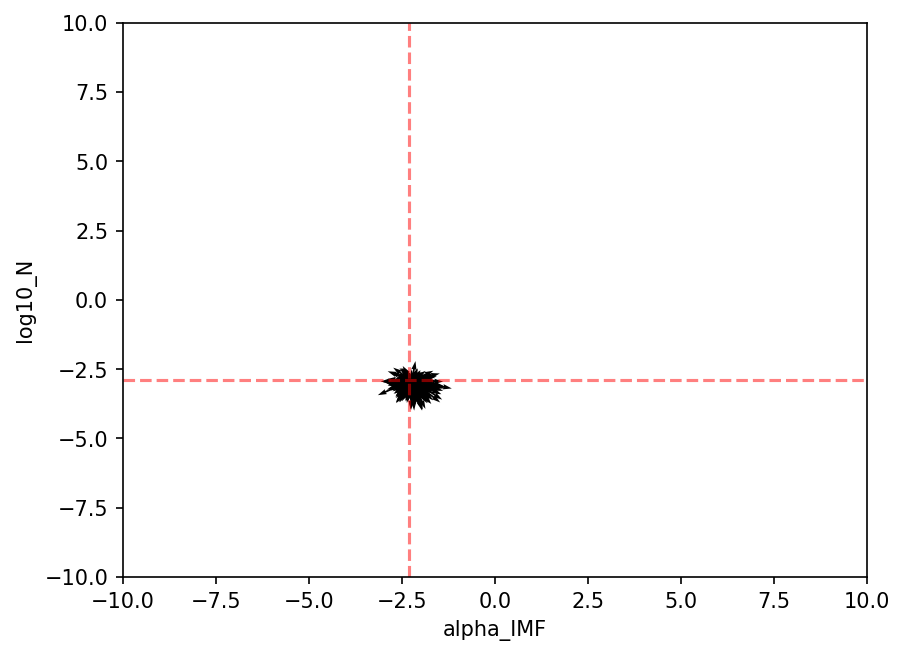

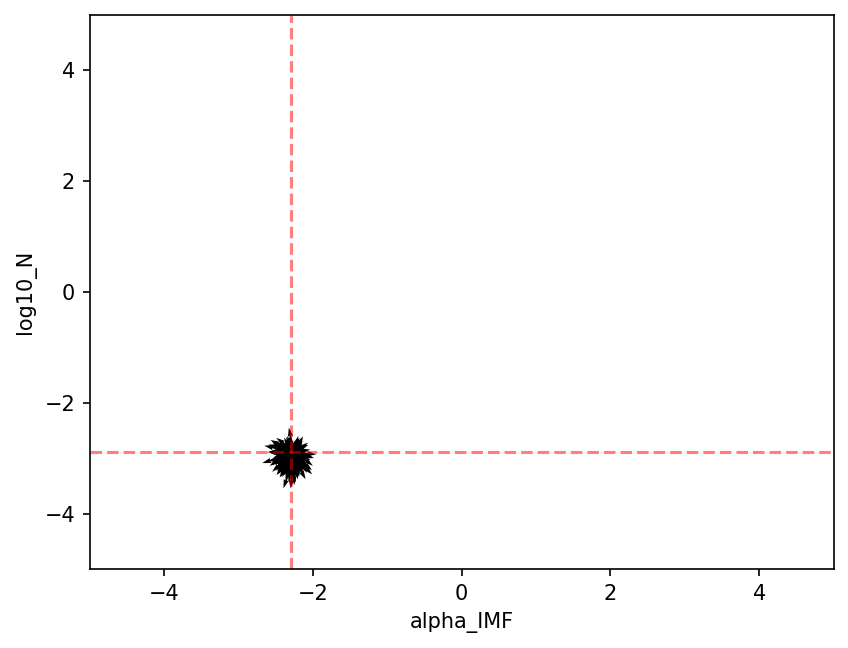

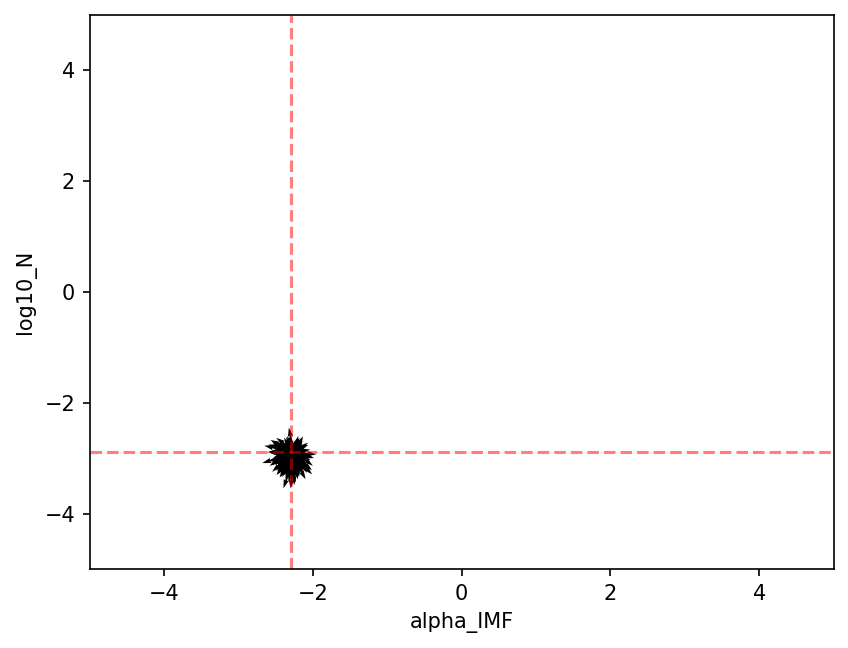

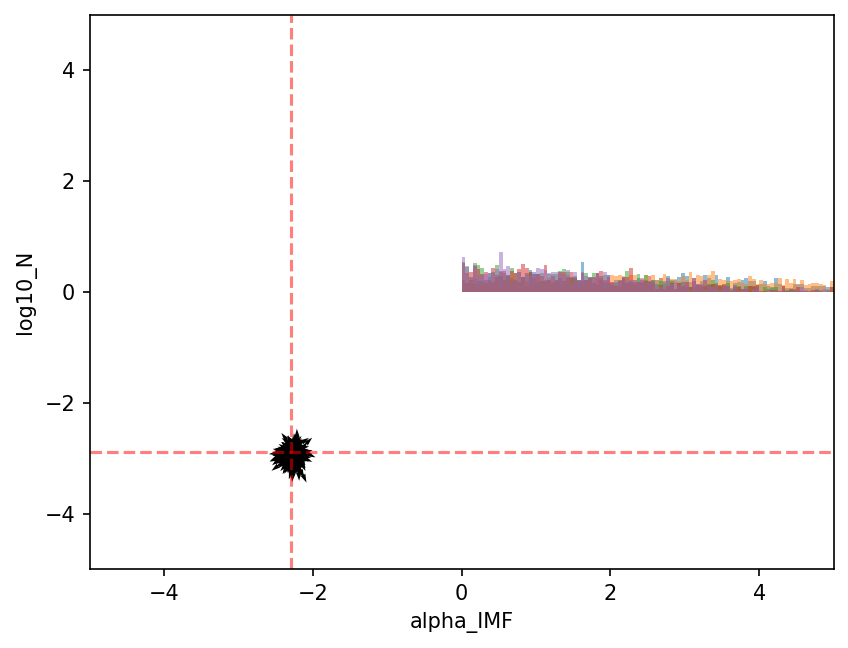

In [37]:
priors = [-2.3, -2.89, -0.3, 0.55, 0.5]
sigma = [0.3, 0.3, 0.3, 0.1, 0.1]
for i in range(5):
    prior_deviation = abs((sample_data_t1[:, i]-priors[i]))
    plt.hist(prior_deviation, bins=100, density=True, alpha=0.5, range=(0,5));

plt.show()

In [38]:
denoising_data = simformer.x_t.detach().numpy()
score_t = simformer.score_t.detach().numpy()
t = simformer.t.detach().numpy()

In [39]:
denoising_data.shape

(1000, 301, 14)

In [44]:
scaling_factor = -0.5*simformer.sigma**(2*t)*(1/T)

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

def animate(i):
    plt.clf()
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.xlabel('alpha_IMF')
    plt.ylabel('log10_N')
    plt.axvline(priors[0], color='r', ls="--", alpha=0.5)
    plt.axhline(priors[1], color='r', ls="--", alpha=0.5)

    plt.quiver(denoising_data[:,i,0], denoising_data[:,i,1], score_t[:,i,0]*scaling_factor[i], score_t[:,i,1]*scaling_factor[i])

    #plt.scatter(denoising_data[:,i,0], denoising_data[:,i,1], s=0.5)
    #for j in range(len(denoising_data)):
    #    plt.arrow(denoising_data[j,i,0], denoising_data[j,i,1], score_t[j,i,0]*scaling_factor[i], score_t[j,i,1]*scaling_factor[i], color='black', head_width=0.05, alpha=0.6)

ani2 = matplotlib.animation.FuncAnimation(fig, animate, frames=20) 

writer = matplotlib.animation.PillowWriter(fps=5,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani2.save('plots/test_big.gif', writer=writer)

"""
plt.scatter(denoising_data[:,0,0], denoising_data[:,0,1], s=0.5)
for i in range(len(denoising_data)):
    plt.arrow(denoising_data[i,0,0], denoising_data[i,0,1], score_t[i,0,0]*scaling_factor[0], score_t[i,0,1]*scaling_factor[0], color='b', head_width=0.03)

plt.show()"""

"\nplt.scatter(denoising_data[:,0,0], denoising_data[:,0,1], s=0.5)\nfor i in range(len(denoising_data)):\n    plt.arrow(denoising_data[i,0,0], denoising_data[i,0,1], score_t[i,0,0]*scaling_factor[0], score_t[i,0,1]*scaling_factor[0], color='b', head_width=0.03)\n\nplt.show()"

In [ ]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

t = torch.linspace(0, 1, T)

def animate2(i):
    data_t = denoising_data[:,i,:6]
    plt.cla()
    for n in range(data_t.shape[1]):
        plt.hist(data_t[:,n], bins=500, range=(-2,2), density=True, alpha=0.5)
    plt.xlim([-2,2])
    plt.ylim([0,2.5])
    plt.title(f"t={int(i)}")

ani2 = matplotlib.animation.FuncAnimation(fig, animate2, frames=299) 

writer = matplotlib.animation.PillowWriter(fps=20,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani2.save('plots/noise_to_x.gif', writer=writer)

In [ ]:
color = ['red', 'blue', 'green', 'purple', 'orange', 'black']

for i in range(5):
    plt.hist(sample_data_t0[:, i], bins=500, range=(-5,5), density=True, alpha=0.5, color=color[i])
plt.show()

# Animate Diffusion Process
Diffusion process to create the data for score training.

In [ ]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

t = torch.linspace(0, 1, T)
color = ['red', 'blue', 'green', 'purple', 'orange', 'black']

def animate(i):
    data_t = simformer.forward_diffusion_sample(data[:,:6], t[i])
    plt.cla()
    for n in range(data_t.shape[1]):
        plt.hist(data_t[:,n], bins=500, range=(-5,15), density=True, alpha=0.5, color=color[n])
    plt.xlim([-5,15])
    plt.ylim([0,1])
    plt.title(f"t={int(i)}")

"""
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=299)

writer = matplotlib.animation.PillowWriter(fps=20,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('../plots/theta_to_noise.gif', writer=writer)
"""
matplotlib.animation.FuncAnimation(fig, animate, frames=10)

In [ ]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

t = torch.linspace(0, 1, T)

def animate2(i):
    data_t = simformer.forward_diffusion_sample(data[:,7:], t[i])
    plt.cla()
    for n in range(data_t.shape[1]):
        plt.hist(data_t[:,n], bins=500, range=(-2,2), density=True, alpha=0.5)
    plt.xlim([-2,2])
    plt.ylim([0,2.5])
    plt.title(f"t={int(i)}")

ani2 = matplotlib.animation.FuncAnimation(fig, animate2, frames=299) 

writer = matplotlib.animation.PillowWriter(fps=20,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani2.save('../plots/x_to_noise.gif', writer=writer)

# Transformer forward pass

In [ ]:
torch.ones(data[:10].shape[0],1)*10

In [ ]:
score = simformer.forward_transformer(data[:10], torch.ones(data[:10].shape[0],1)*10, condition_mask=torch.ones_like(data[:10]))

In [ ]:
score.shape

In [ ]:
score